In [1]:
import pandas as pd
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
import statsmodels
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
from collections import defaultdict
from tqdm.notebook import tqdm


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS

from mri_data import file_manager as fm

## Load Data

In [4]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/sdmt_regressions"
)

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
)

ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid"
)
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")

df = df.join([choroid_volumes, ventricle_volumes, tiv, sdmt['SDMT'], df_thomas['1-THALAMUS']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')
df.rename(columns={'1-THALAMUS': 'whole_thalamus'}, inplace=True)

df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

df_ms = df[df['dz_type2'] == "MS"]
df_ms_z = df_ms.copy()
df_ms_z[numeric_cols] = df_ms_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

# assert df.loc[1340, 'EDSS'] == 2.5

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

In [3]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_norm = df_thomas_left.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")
df_thomas_left_norm_z = df_thomas_left_norm.apply(stats.zscore, nan_policy="omit")


df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_norm = df_thomas_right.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")
df_thomas_right_norm_z = df_thomas_right_norm.apply(stats.zscore, nan_policy="omit")


thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_centroid-left.csv", index_col="subid")
ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

mni_choroid_dists = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni-centroid-choroid_SDT2.csv")

def combine_nuclei(df):
    df2 = pd.DataFrame()
    df2['anterior'] = df['AV_2']
    df2['ventral'] = df['VA_4'] + df['VLa_5'] + df['VLP_6'] + df['VPL_7']
    df2['intralaminar'] = df['CM_11'] 
    df2['medial'] = df['MD_Pf_12']
    df2['posterior'] = df['Pul_8'] + df['LGN_9'] + df['MGN_10']
    df2['THALAMUS_1'] = df['THALAMUS_1']
    return df2

df_thomas2 = combine_nuclei(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

df_thomas2_left = combine_nuclei(df_thomas_left)
df_thomas2_left_z = df_thomas2_left.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_left = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_left_z = df_thomas2_norm_left.apply(stats.zscore, nan_policy="omit")

df_thomas2_right = combine_nuclei(df_thomas_right)
df_thomas2_right_z = df_thomas2_right.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm_right = df_thomas2.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas2_norm_right_z = df_thomas2_norm_right.apply(stats.zscore, nan_policy="omit")

## Functions

In [5]:
def plot_regression(
    data, predictor, outcome, covariates, xlabel=None, ylabel=None, title=None
):
    plus_covariates = ""
    if len(covariates) > 0:
        plus_covariates = f"+ {' + '.join(covariates)}"
    if xlabel is None:
        xlabel = predictor
    if ylabel is None:
        ylabel = outcome
    if title is None:
        title = f"{outcome} vs {predictor}"

    formula = f"{outcome} ~ {predictor} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(data, res, predictor, outcome)

    fig, axs = plt.subplot_mosaic(
        [['histx', '.'], ['scatter', 'histy']],
        figsize=(8, 6),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout='constrained',
    )

    helpers.scatter_hist(
        data[predictor],
        data[outcome],
        axs['scatter'],
        axs['histx'],
        axs['histy'],
        light_color=colors['light blue1'],
        dark_color=colors['dark blue1'],
    )

    axs['scatter'].plot(x, y_pred, color="black")
    axs['scatter'].fill_between(
        x, y_lims[0], y_lims[1], alpha=0.4, color=colors["light blue1"]
    )
    axs['scatter'].set_ylabel(ylabel)
    axs['scatter'].set_xlabel(xlabel)
    fig.suptitle(title)
    return fig, axs

## Assumption Checks

SDMT looks normal enough, probably don't need to test further

(array([  4.,  18.,  23.,  50.,  70., 110.,  95.,  50.,  25.,   9.]),
 array([11. , 18.6, 26.2, 33.8, 41.4, 49. , 56.6, 64.2, 71.8, 79.4, 87. ]),
 <BarContainer object of 10 artists>)

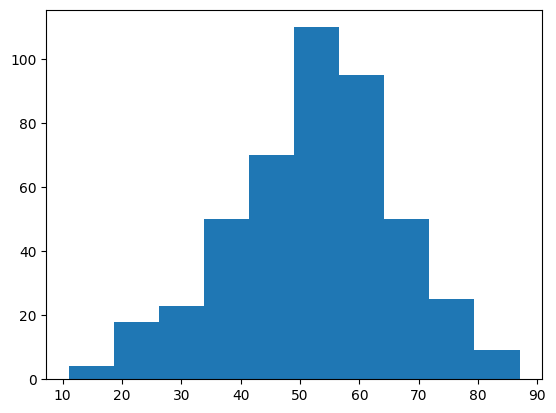

In [ ]:
plt.hist(df['SDMT'])

## Regressions

Regress SDMT against various MRI features independently

In [9]:
model_data = df_ms_z.join(df_thomas_z)
covariates = "age + Female + tiv"

outcome = "SDMT"
predictors = [
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "THALAMUS_1",
    "t2lv",
    "PRL",
    "choroid_volume",
    "ventricle_volume"
]

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
r2 = {}
ci_str = {}

for x in predictors:
    formula = f"{outcome} ~ {x} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[x] = res.pvalues[x]
    coefs[x] = res.params[x]
    stderrs[x] = res.HC0_se[x]
    ci = res.conf_int()
    llci[x] = ci.loc[x, 0]
    ulci[x] = ci.loc[x, 1]
    ci_str[x] = f"[{llci[x]:.6f}, {ulci[x]:.6f}]"
    r2[x] = res.rsquared_adj


regression_results = pd.DataFrame(
    {
        "coef": coefs,
        "stderr": stderrs,
        "llci": llci,
        "ulci": ulci,
        "pvals": pvals,
        "ci": ci_str,
    }
)
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.index.name = "structure"
regression_results.to_excel(fig_path / "SDMT_and_main_mri_features_MS.xlsx")
regression_results


,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
structure,,,,,,,,
brain,0.233121,0.046616,0.136631,0.329612,2.766091e-06,"[0.136631, 0.329612]",4.149137e-06,0.195320
white,0.104404,0.046018,0.013419,0.195390,2.460754e-02,"[0.013419, 0.195390]",2.460754e-02,0.164381
grey,0.291232,0.048228,0.190863,0.391600,2.143769e-08,"[0.190863, 0.391600]",3.858785e-08,0.211987
cortical_thickness,0.361019,0.047684,0.269593,0.452445,5.762797e-14,"[0.269593, 0.452445]",5.186517e-13,0.254860
THALAMUS_1,0.355909,0.054672,0.261354,0.450463,6.881416e-13,"[0.261354, 0.450463]",3.096637e-12,0.246721
t2lv,-0.266237,0.073334,-0.349392,-0.183082,7.447195e-10,"[-0.349392, -0.183082]",2.234158e-09,0.223395
PRL,-0.145967,0.047596,-0.233574,-0.058360,1.140599e-03,"[-0.233574, -0.058360]",1.390571e-03,0.174626
choroid_volume,-0.157975,0.055039,-0.253469,-0.062481,1.236063e-03,"[-0.253469, -0.062481]",1.390571e-03,0.174353
ventricle_volume,-0.284867,0.058036,-0.378444,-0.191289,4.496924e-09,"[-0.378444, -0.191289]",1.011808e-08,0.218472


### SDMT in PMS vs RMS

Patients with PMS had lower SDMT after adjusting for age, sex, and TIV

In [58]:
model_data = df_ms_z.copy()
model_data = pd.concat(
    (model_data, pd.get_dummies(model_data['dz_type5'], dtype="int")), axis=1
)

formula = "PMS ~ SDMT + age + tiv + Female"
res = sm.Logit.from_formula(formula, data=model_data).fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.341385
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    PMS   No. Observations:                  454
Model:                          Logit   Df Residuals:                      449
Method:                           MLE   Df Model:                            4
Date:                Wed, 11 Jun 2025   Pseudo R-squ.:                  0.3306
Time:                        17:57:41   Log-Likelihood:                -154.99
converged:                       True   LL-Null:                       -231.55
Covariance Type:            nonrobust   LLR p-value:                 4.366e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1913      0.206    -10.636      0.000      -2.595      -1.788
SDMT          -0.9455      0.

## HIPS-THOMAS

### L/R for thalamus diagram

In [54]:
model_data = df_z.join(df_thomas_left_norm_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_left = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results_left['p_fdr'] = stats.false_discovery_control(regression_results_left['pvals'], method='bh')
regression_results_left.sort_values(by="coef")

,coef,pvals,p_fdr
VA_4,-0.262960,3.266247e-08,3.266247e-07
VLa_5,-0.213311,2.237891e-06,9.942127e-06
MGN_10,-0.156869,2.010441e-03,4.020882e-03
VLP_6,-0.065037,1.470572e-01,2.100817e-01
VPL_7,-0.023167,6.089168e-01,6.765743e-01
CM_11,-0.004689,9.163446e-01,9.163446e-01
MD_Pf_12,0.045235,2.960194e-01,3.700243e-01
LGN_9,0.093818,2.809813e-02,4.683022e-02
Pul_8,0.168298,7.290840e-05,1.822710e-04
AV_2,0.213292,2.982638e-06,9.942127e-06


In [55]:
model_data = df_z.join(df_thomas_right_norm_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']

model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_right = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results_right['p_fdr'] = stats.false_discovery_control(regression_results_right['pvals'], method='bh')
regression_results_right.sort_values(by="coef")
# regression_results_right

,coef,pvals,p_fdr
VA_4,-0.214894,0.000001,0.000011
VLa_5,-0.190561,0.000030,0.000148
MGN_10,-0.127389,0.004735,0.011597
VLP_6,-0.050455,0.256733,0.366762
CM_11,-0.041793,0.370177,0.462721
MD_Pf_12,-0.018369,0.667580,0.741756
VPL_7,0.012518,0.778396,0.778396
AV_2,0.089878,0.051017,0.085028
LGN_9,0.121233,0.005798,0.011597
Pul_8,0.132920,0.002016,0.006720


In [56]:
all_coefs = pd.concat([regression_results_left.coef, regression_results_right.coef])
bins = np.linspace(all_coefs.min()-0.0001, all_coefs.max()-0.0001, 10)
regression_results_left['coef_bin'] = np.digitize(regression_results_left['coef'], bins)
regression_results_right['coef_bin'] = np.digitize(regression_results_right['coef'], bins)
print(regression_results_left.sort_values(by="coef_bin")['coef_bin'])
print(regression_results_right.sort_values(by="coef_bin")['coef_bin'])
print(all_coefs.min()-0.0001, all_coefs.max()-0.0001)

VA_4         1
VLa_5        1
MGN_10       3
VLP_6        4
VPL_7        5
CM_11        5
MD_Pf_12     6
LGN_9        7
Pul_8        9
AV_2        10
Name: coef_bin, dtype: int64
VA_4        1
VLa_5       2
MGN_10      3
VLP_6       5
CM_11       5
MD_Pf_12    5
VPL_7       6
AV_2        7
Pul_8       8
LGN_9       8
Name: coef_bin, dtype: int64
-0.2630601602168975 0.21319185463718873


In [57]:
model_data = df_z.join(df_thomas_left_norm_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "EDSS_sqrt"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_left = pd.DataFrame({"coef": coefs, "pvals": pvals})

model_data = df_z.join(df_thomas_right_norm_z)
model_data['whole_thalamus'] = df_thomas_z['THALAMUS_1']

model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "EDSS_sqrt"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj

regression_results_right = pd.DataFrame({"coef": coefs, "pvals": pvals})

EDSS_coefs = pd.concat([regression_results_left.coef, regression_results_right.coef])
SDMT_coefs = all_coefs

PearsonRResult(statistic=-0.9346636631370112, pvalue=1.6231894381482545e-09)

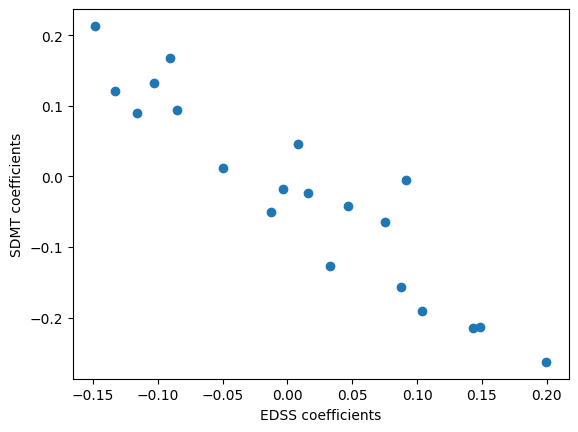

In [60]:
plt.scatter(EDSS_coefs, SDMT_coefs)
plt.xlabel("EDSS coefficients")
plt.ylabel("SDMT coefficients")
stats.pearsonr(EDSS_coefs, SDMT_coefs)

In [ ]:
model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = thalamic_nuclei + [1]
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True, ascending=False)
regression_results.to_excel(fig_path / "thalamic_nuclei.xlsx")
main_coefs = np.array([coefs[hips_thomas_ref[x]] for x in structs])

regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
THALAMUS_1,0.349394,0.057068,0.251523,0.447264,8.503268e-12,"[0.251523, 0.447264]",6.901743e-11,0.260252
Pul_8,0.322647,0.053283,0.231482,0.413813,1.254862e-11,"[0.231482, 0.413813]",6.901743e-11,0.258800
VLP_6,0.314882,0.056524,0.213096,0.416669,2.583892e-09,"[0.213096, 0.416669]",7.105703e-09,0.233986
AV_2,0.298352,0.047016,0.200579,0.396125,4.149486e-09,"[0.200579, 0.396125]",9.128870e-09,0.223062
MD_Pf_12,0.295248,0.051669,0.201886,0.388609,1.176907e-09,"[0.201886, 0.388609]",4.315327e-09,0.238101
CM_11,0.286602,0.050193,0.188608,0.384595,1.675085e-08,"[0.188608, 0.384595]",2.533907e-08,0.223170
VPL_7,0.278496,0.051341,0.182986,0.374006,1.842841e-08,"[0.182986, 0.374006]",2.533907e-08,0.235567
LGN_9,0.265388,0.047121,0.176998,0.353778,7.156746e-09,"[0.176998, 0.353778]",1.312070e-08,0.244404
MGN_10,0.233313,0.054358,0.135054,0.331572,4.054489e-06,"[0.135054, 0.331572]",4.955487e-06,0.225182
VLa_5,0.228045,0.053527,0.119490,0.336601,4.356906e-05,"[0.119490, 0.336601]",4.792597e-05,0.190529


In [ ]:
model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv + THALAMUS_1"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}
thal_coefs = {}


outcome = "SDMT"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    thal_coefs[col] = res.params['THALAMUS_1']
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "thal_coef": thal_coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True, ascending=False)
regression_results.to_excel(fig_path / "thalamic_nuclei_thalamus_control.xlsx")
main_coefs = np.array([coefs[hips_thomas_ref[x]] for x in structs])

regression_results

,coef,thal_coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
AV_2,0.100603,0.302471,0.061394,-0.027541,0.228748,0.123562,"[-0.027541, 0.228748]",0.629419,0.255993
Pul_8,0.096626,0.260219,0.120298,-0.147797,0.341049,0.437614,"[-0.147797, 0.341049]",0.764712,0.263468
LGN_9,0.095094,0.272051,0.063079,-0.026783,0.216972,0.125884,"[-0.026783, 0.216972]",0.629419,0.267948
CM_11,0.084226,0.303355,0.065453,-0.046404,0.214856,0.205760,"[-0.046404, 0.214856]",0.685866,0.255062
VLP_6,0.044734,0.314774,0.086673,-0.142613,0.232082,0.639107,"[-0.142613, 0.232082]",0.861917,0.251220
VLa_5,0.014796,0.355654,0.062652,-0.111788,0.141380,0.818415,"[-0.111788, 0.141380]",0.861917,0.247245
VPL_7,0.014258,0.338452,0.072254,-0.146752,0.175268,0.861917,"[-0.146752, 0.175268]",0.861917,0.260028
MD_Pf_12,-0.030916,0.382836,0.119022,-0.249257,0.187424,0.780926,"[-0.249257, 0.187424]",0.861917,0.253955
VA_4,-0.051533,0.392674,0.073424,-0.188131,0.085066,0.458827,"[-0.188131, 0.085066]",0.764712,0.248956
MGN_10,-0.058211,0.393986,0.069958,-0.202988,0.086566,0.429832,"[-0.202988, 0.086566]",0.764712,0.268857


In [ ]:
model_data = df_z.join(df_thomas_norm_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}
stderrs = {}
llci = {}
ulci = {}
ci_str = {}
r2 = {}

outcome = "SDMT"

structs = thalamic_nuclei
all_results = {}
for x in structs:
    col = hips_thomas_ref[x]
    formula = f"{outcome} ~ {col}*dzdur + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    all_results[col] = res
    pvals[col] = res.pvalues[col]
    coefs[col] = res.params[col]
    stderrs[col] = res.HC0_se[col]
    ci = res.conf_int()
    llci[col] = ci.loc[col, 0]
    ulci[col] = ci.loc[col, 1]
    ci_str[col] = f"[{llci[col]:.6f}, {ulci[col]:.6f}]"
    r2[col] = res.rsquared_adj



regression_results = pd.DataFrame({"coef": coefs, "stderr": stderrs, "llci": llci, "ulci": ulci, "pvals": pvals, "ci": ci_str})
regression_results['p_fdr'] = stats.false_discovery_control(
    regression_results['pvals'], method='bh'
)
regression_results['R2'] = r2
regression_results.sort_values(by="coef", inplace=True, ascending=False)
regression_results.to_excel(fig_path / "thalamic_nuclei_normed.xlsx")
main_coefs = np.array([coefs[hips_thomas_ref[x]] for x in structs])

regression_results

,coef,stderr,llci,ulci,pvals,ci,p_fdr,R2
Pul_8,0.199977,0.047148,0.116089,0.283865,3.721612e-06,"[0.116089, 0.283865]",1.240537e-05,0.204514
AV_2,0.180753,0.044608,0.088866,0.272640,1.270634e-04,"[0.088866, 0.272640]",3.176584e-04,0.181646
LGN_9,0.129755,0.045161,0.044823,0.214687,2.828058e-03,"[0.044823, 0.214687]",4.713429e-03,0.188077
MD_Pf_12,0.019645,0.050391,-0.065440,0.104730,6.502259e-01,"[-0.065440, 0.104730]",7.224733e-01,0.153305
VPL_7,-0.002775,0.042502,-0.090754,0.085204,9.505973e-01,"[-0.090754, 0.085204]",9.505973e-01,0.153301
CM_11,-0.029204,0.047901,-0.120636,0.062229,5.305131e-01,"[-0.120636, 0.062229]",6.631414e-01,0.156540
VLP_6,-0.084482,0.047103,-0.175760,0.006796,6.958513e-02,"[-0.175760, 0.006796]",9.940733e-02,0.162600
MGN_10,-0.179724,0.050939,-0.275801,-0.083648,2.653626e-04,"[-0.275801, -0.083648]",5.307252e-04,0.178066
VLa_5,-0.226677,0.050491,-0.315094,-0.138260,6.824858e-07,"[-0.315094, -0.138260]",3.412429e-06,0.229023
VA_4,-0.262605,0.049693,-0.350500,-0.174709,8.425507e-09,"[-0.350500, -0.174709]",8.425507e-08,0.243338
